In [21]:
import gymnasium as gym
import numpy as np
import torch
import os
import time
import gc
import pickle
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchmetrics.classification import MulticlassAccuracy
import matplotlib.pyplot as plt

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [22]:
class Q_net(nn.Module):
    def __init__(self, input_shape, output_size, layer_size=128, num_layers = 1, action_depth=4):
        #input_shape is normally [210, 160] for grayscale
        super(Q_net, self).__init__()
        # VGG16
        # Define shape of VGG architecture
        # Each entry is ('Conv', num_filters, kernel_size) or ('Pool', pool_size, strides)
        self.vgg_layers_desc = [
            ('Conv', 64, 3), 
            ('Pool', 2, 2)
        ]
        current_shape = (input_shape[0], action_depth, input_shape[2], input_shape[3]) # Add channel dimension at index 1 -> (num_samples, num_channeels, width, height)
        self.layers = nn.ModuleList()
        for layer_idx, layer in enumerate(self.vgg_layers_desc):
            if layer[0] == 'Conv':
                kernel_size = layer[2]
                out_channels = layer[1]
                in_channels = current_shape[1]
                self.layers.extend([
                    nn.Conv2d(in_channels, out_channels, kernel_size, padding=1),
                    nn.ReLU()
                ])
                # Update current shape
                current_shape = (current_shape[0], out_channels, current_shape[2], current_shape[3])
            elif layer[0] == 'Pool':
                kernel_size = layer[1]
                stride = layer[2]
                self.layers.append(
                    nn.MaxPool2d(kernel_size, stride),
                )
                #Update current shape
                new_width = np.floor(current_shape[2]/2).astype(int)
                new_height = np.floor(current_shape[3]/2).astype(int)
                current_shape = (current_shape[0], current_shape[1], new_width, new_height)
        current_len = int(torch.prod(torch.Tensor(current_shape[1:])))
        self.layers.append(nn.Flatten())
        self.layers.append(nn.Linear(current_len, layer_size))
        self.layers.append(nn.ReLU())
        for layer_idx in range(num_layers):
            self.layers.extend([
                nn.Linear(layer_size, layer_size),
                nn.ReLU()
            ])
        self.layers.append(nn.Linear(layer_size, output_size))
        self.zero_grad
    def forward(self, x):
        for layer_idx, layer in enumerate(self.layers):
            x = layer(x)
        return x

In [23]:
class Asteroids_Dataset(Dataset):
    def __init__(self, DQL_Agent, action_depth = 4):
        self.env = gym.make('Asteroids-v4', obs_type="grayscale")
        obs, info = self.env.reset()
        # Items store for each step: action, reward, next_state. Note: states starts filled with intro obs
        actions = []
        rewards = []
        states = [obs] # Note, only storing each state once to save on memory, next state will just be obs at (i+1)
        terminated = False
        truncated = False
        lives = 4
        while not terminated and not truncated:
            if np.random.rand(1) < DQL_Agent.epsilon or len(states) < action_depth:
                # Find a random action
                action = self.env.action_space.sample()
            else:
                # Find best action via current_net
                action_probs = DQL_Agent.current_net(Asteroids_Dataset.prep_input(states[-action_depth:], action_depth))
                action = torch.argmax(action_probs)
            obs, reward, terminated, truncated, info = self.env.step(action)
            # Custom reward for losing a life
            if info['lives'] < lives:
                reward -= 100
                lives = info['lives']
            actions.append(action)
            rewards.append(reward)
            states.append(obs)
        # Format each data piece into the correct tensor shape for neural network
        prepped_states = Asteroids_Dataset.prep_input(states, action_depth)
        # current states are all but the final state
        self.current_states = prepped_states[:-1]
        # nexst states are all but the first state
        self.next_states = prepped_states[1:]
        self.rewards = torch.tensor(rewards[action_depth-1:])
        self.actions = F.one_hot(torch.tensor(actions[action_depth-1:]), num_classes = self.env.action_space.n)
        
     # Reshape a list of observations into a tensor of the correct input shape
    def prep_input(obs_list, action_depth):
        out_tensor = torch.zeros([len(obs_list)-action_depth + 1, action_depth, 210, 160])
        # Set first obs to iterate off of
        for idx in range(0, action_depth):
            out_tensor[0, idx, :, :] = torch.tensor(obs_list[idx]).to(torch.float32)
        # Set the rest by duplicating previous Note: idx here refers to the out tensor, not the input. out_tensor[0] = obs_list[action_depth] 
        for idx in range(1, len(obs_list)-action_depth):
            out_tensor[idx, :action_depth-1, :, :] = out_tensor[idx-1, 1:action_depth, :, :]
            out_tensor[idx, action_depth-1, :, :] = torch.tensor(obs_list[idx+action_depth]).to(torch.float32)
        return out_tensor
    
    def __len__(self):
        return len(self.rewards)

    def __getitem__(self, idx):
        if idx < len(self):
            return self.current_states[idx], self.next_states[idx], self.rewards[idx], self.actions[idx]
        else:
            return None

In [24]:
class DQL_Agent:
    def __init__(self, gamma, action_depth = 4):
        self.current_net = Q_net([1, action_depth, 210, 160], 14)
        self.next_net = Q_net([1, action_depth, 210, 160], 14)
        self.action_depth = action_depth
        self.gamma = gamma
        self.epsilon = .99
        self.num_games = 0
    def learn(self, num_episodes, batch_size=128, lr = 1e-5, model_update_freq = 10):
        loss_fn = nn.MSELoss()
        optim = torch.optim.Adam(self.current_net.parameters(), lr=lr)
        total_rewards = torch.zeros(num_episodes)
        for episode in range(num_episodes):
            dataset = Asteroids_Dataset(self, self.action_depth)
            dataloader = DataLoader(dataset, batch_size=batch_size)
            for step, [current_states, next_states, rewards, actions] in enumerate(dataloader):
                # Note: q_pred is the current net's prediction for the q value of the current state action pair
                # Computed by multiplying a one hot encoding of the actions by the output of network
                # Network output has shape of [batch_size, num_actions], meaning if multiplied by one hot encoding of action space will return zero for all actions not taken
                # Max operator is to single out the action taken from the other zeros in the row
                q_pred, _ = torch.max(self.current_net(current_states)*actions, dim=1) 
                # Note: q_next_max is just a partial portion of q_target, being the evaluation of the next_net at the given states taken at the maximal action
                q_next_max, _ = torch.max(self.next_net(next_states), dim=1)
                q_target = rewards + self.gamma*q_next_max
                # Learning portion
                optim.zero_grad()
                loss = loss_fn(q_target, q_pred)
                print(f"Episode : {episode} Batch : {step} Loss : {loss}")
                loss.backward()
                optim.step()
            if episode % model_update_freq == 0:
                self.next_net.load_state_dict(self.current_net.state_dict())
            self.epsilon = self.epsilon * .9999
            total_rewards[episode] = sum(rewards)
        self.num_games += num_episodes
        return total_rewards
    # Allow viewing of the best actions known by model
    def play_and_watch(self):
        env = gym.make('Asteroids-v4', obs_type="grayscale", render_mode="human")
        obs, _ = env.reset()
        terminated = False
        truncated = False
        states = self.action_depth*[obs] # Begin with action depth copies of initial observation
        while not terminated and not truncated:
            # Find best action via current_net
            action_probs = self.current_net(Asteroids_Dataset.prep_input(states[-self.action_depth:], self.action_depth))
            action = torch.argmax(action_probs)
            obs, reward, terminated, truncated, info = env.step(action)
            states.append(obs)
        env.close()

In [25]:
# Training loop
version = 1
num_episodes = 0
model = DQL_Agent(gamma=.9)
# # Load model if it exists
# if os.path.isfile(f"DQN_current_V{version}.pt") and os.path.isfile(f"DQN_next_V{version}.pt") and os.path.isfile(f"DQN_total_rewards_V{version}.txt"):
#     model.current_net.load_state_dict(torch.load(f"DQN_current_V{version}.pt"))
#     model.next_net.load_state_dict(torch.load(f"DQN_next_V{version}.pt"))
#     with open(f"DQN_total_rewards_V{version}.txt", "rb") as rewards_file:
#         total_rewards = pickle.load(rewards_file)
#     with open(f"DQN_epsilon_V{version}.txt", "rb") as ep_file:
#         model.epsilon= pickle.load(ep_file)
#     rewards_file.close()
#     ep_file.close()
#     model.num_games = len(total_rewards)
# else:
total_rewards = []
total_rewards.extend(model.learn(num_episodes=num_episodes).tolist())
torch.save(model.current_net.state_dict(), f"DQN_current_V{version}.pt")
torch.save(model.next_net.state_dict(), f"DQN_next_V{version}.pt")
with open(f"DQN_total_rewards_V{version}.txt", "wb") as rewards_file:
    pickle.dump(total_rewards, rewards_file)
with open(f"DQN_epsilon_V{version}.txt", "wb") as ep_file:
    pickle.dump(model.epsilon, ep_file)
rewards_file.close()
ep_file.close()
print(200*" ")
print(f"Number of games played so far:{model.num_games}")

                                                                                                                                                                                                        
Number of games played so far:0


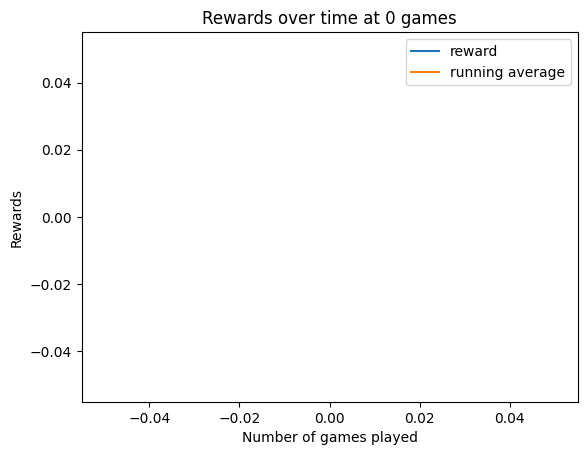

In [26]:
# Generate moving average
running_average = np.zeros(len(total_rewards))
total = 0
for idx, reward in enumerate(total_rewards):
    total += reward
    running_average[idx] = total/(idx + 1)
# Plot model
plt.title(f"Rewards over time at {model.num_games} games")
plt.plot(total_rewards, label="reward")
plt.plot(running_average, label="running average")
plt.xlabel("Number of games played")
plt.ylabel("Rewards")
plt.legend()

In [163]:
env = gym.make('Asteroids-v4', obs_type="rgb", render_mode="human")
state, _ = env.reset()
for i in range(10):
    while True:
        action = env.action_space.sample()
        state, reward, terminated, truncated, info = env.step(action)
        if terminated or truncated:
            break
env.close()


2024-04-09 11:56:43.777 Python[38124:19522674] WARNING: Secure coding is automatically enabled for restorable state! However, not on all supported macOS versions of this application. Opt-in to secure coding explicitly by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState:.


: 